# Evaluation of VAE LSTM Network in Anomaly Detection

Code by Thinh Hoang (dthoang@artimensium.com) from the original paper

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from arch_skip import VAE_LSTM_Model
from config import train_configurations
model = VAE_LSTM_Model(train_configurations)

In [3]:
# Load the weights of the VAE
model.load_vae_weights('../vae_weights.pth')

In [4]:
# Load the weights of the LSTM
model.load_lstm_weights('../lstm_weights.pth')

# Let's Test. Hopefully it will work, otherwise my paper is delayed again :(

In [5]:
# Append NGSIM folder to the search path
from ngsim_lstm_dataset import NGSIM_PreEmbeddings_Dataset

ngsim_pee_ds = NGSIM_PreEmbeddings_Dataset(unroll_filepath='../NGSIM_Dataset/unrolled_data.npy',
                                   bond_filepath='../NGSIM_Dataset/bond_data.pkl',
                                   column=3) # velocity
print(f'Dataset loaded. Shape: {ngsim_pee_ds.unrolled_data.shape}')

Dataset loaded. Shape: (23400, 1, 32)


Expected velocity:  39.5653125
Expected velocity:  38.60624999999999


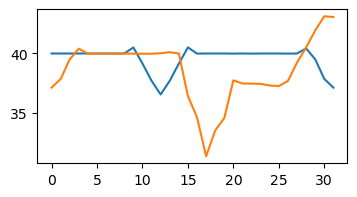

In [28]:
# Let's plot the first sequence
import matplotlib.pyplot as plt
import numpy as np

seq1 = ngsim_pee_ds.unrolled_data[0]
print('Expected velocity: ', np.mean(seq1.flatten()))
seq2 = ngsim_pee_ds.unrolled_data[31]
print('Expected velocity: ', np.mean(seq2.flatten()))
plt.figure(figsize=(4,2))
plt.plot(seq1.flatten())
plt.plot(seq2.flatten())

In [32]:
# We can cumsum the first sequence
x1 = np.cumsum(seq1.flatten())
x2 = np.cumsum(seq2.flatten())

In [1]:
n_samples = 100 # number of Monte Carlo samples
seq_pred = model.predict_sequence(seq1.reshape(1, 1, -1))
plt.figure(figsize=(4,2))
plt.plot(seq_pred.flatten())
plt.show()

print('Expected velocity:', np.mean(seq_pred))
x2p = np.cumsum(seq_pred.flatten())

plt.figure(figsize=(4,2))
plt.plot(x1)
plt.plot(len(x1) + np.arange(len(x2)), x2 + x1[-1])
plt.plot(len(x1) + np.arange(len(x2p)), x2p + x1[-1])
plt.xlabel('Timestep')
plt.ylabel('Longitudinal Position')

NameError: name 'model' is not defined